In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Import our project modules
from challenge.data.ingest import load_data
from challenge.data.feature_selection import select_features_ks
from challenge.modelling.train_eval import cv_cost, evaluate_on_test
from challenge.visualization.performance_viz import plot_confusion, plot_cost_threshold_curve
# Import ML models and tools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import warnings
from sklearn.exceptions import ConvergenceWarning
# Suppress all warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Configure plotting
%matplotlib inline
sns.set_theme(style="whitegrid")


In [3]:
# --- Configuration ---
DATA_PATH = 'dataset/' # Or './dataset/' which means the same thing
TRAIN_FILE = 'aps_failure_training_set.csv'
TEST_FILE = 'aps_failure_test_set.csv'

# N_SPLITS for cross-validation. 5 is robust, 3 is faster.
N_CV_SPLITS = 5

# MODELS to test
# We test a fast/interpretable linear model and a powerful non-linear one.
# 'class_weight' is a good baseline to use even when not sampling.
MODELS_TO_TEST = {
    'LogisticRegression': LogisticRegression(
        random_state=42, 
        class_weight='balanced', 
        solver='liblinear',  # Good for this dataset size
        C=1.0,               # Default regularization
        max_iter=1000
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1,
        class_weight='balanced'
    )
}

# 2. PIPELINES to test
# We define all 6 combinations of feature selection and sampling.
# 'sampler' maps directly to the `sampler` argument in `cv_cost`.
# 'use_ks_select' is our boolean flag to switch feature sets.
EXPERIMENT_PIPELINES = [
    # --- Group 1: Using ALL 162 features ---
    {
        'name': 'Gaussian Copula',
        'sampler': 'copula',
        'use_ks_select': False
    },
    {
        'name': 'No Sampling',
        'sampler': None,
        'use_ks_select': False
    },
    {
        'name': 'SMOTE',
        'sampler': 'smote',
        'use_ks_select': False
    },
    # --- Group 2: Using K-S Selected (146) features ---
    {
        'name': 'K-S + Gaussian Copula',
        'sampler': 'copula',
        'use_ks_select': True
    },
    {
        'name': 'K-S + (No Sampling)',
        'sampler': None,
        'use_ks_select': True
    },
    {
        'name': 'K-S + SMOTE',
        'sampler': 'smote',
        'use_ks_select': True
    }   
]

In [4]:
# Load raw data
X_train_raw, y_train_raw = load_data(DATA_PATH, TRAIN_FILE)
X_test_raw, y_test_raw = load_data(DATA_PATH, TEST_FILE)

print(f"Raw train shape: {X_train_raw.shape}")
print(f"Raw test shape: {X_test_raw.shape}")

Successfully loaded and processed aps_failure_training_set.csv. X shape: (60000, 170), y shape: (60000,)
Successfully loaded and processed aps_failure_test_set.csv. X shape: (16000, 170), y shape: (16000,)
Raw train shape: (60000, 170)
Raw test shape: (16000, 170)


In [5]:
# 2. Preliminary Cleaning (Training Set Only)
# We apply the rule: "drop rows that have missing values in columns 
# with <= 4% missing values."
# This is a data-cleaning step applied *only* to the training set.

print(f"Original train shape (X, y): {X_train_raw.shape}, {y_train_raw.shape}")

# 1. Find columns with low missingness (0% < NA <= 4%)
na_pct = X_train_raw.isna().mean()
low_na_cols = na_pct[(na_pct > 0) & (na_pct <= 0.04)].index

if not low_na_cols.empty:
    # 2. Find the indices of rows that have *any* NaN in these specific columns
    rows_to_drop = X_train_raw[low_na_cols].isna().any(axis=1)
    
    # 3. Get the indices to drop
    drop_indices = X_train_raw[rows_to_drop].index
    
    # 4. Drop these rows from *both* X_train and y_train
    X_train_raw = X_train_raw.drop(index=drop_indices)
    y_train_raw = y_train_raw.drop(index=drop_indices)
    
    print(f"Identified {len(low_na_cols)} low-NA columns.")
    print(f"Dropped {len(drop_indices)} rows from training set.")
else:
    print("No low-NA columns found. No rows dropped.")

print(f"Cleaned train shape (X, y): {X_train_raw.shape}, {y_train_raw.shape}")
print(f"Test set shape remains: {X_test_raw.shape}, {y_test_raw.shape}")

Original train shape (X, y): (60000, 170), (60000,)
Identified 99 low-NA columns.
Dropped 1873 rows from training set.
Cleaned train shape (X, y): (58127, 170), (58127,)
Test set shape remains: (16000, 170), (16000,)


In [6]:
# Pre-compute the K-S selected feature list
# We do this once, outside the loop.
print("--- Pre-computing K-S feature set ---")
# Use a permissive p-value, we know from EDA it's fine
selected_features = select_features_ks(X_train_raw, y_train_raw, p_value_threshold=0.001)

# Create the filtered DataFrames
X_train_ks = X_train_raw[selected_features]
X_test_ks = X_test_raw[selected_features]

print(f"\nK-S Filtered train shape: {X_train_ks.shape}")

--- Pre-computing K-S feature set ---
Starting K-S test on 170 features...
K-S test complete. Selected 151 out of 170 features.

K-S Filtered train shape: (58127, 151)


In [7]:
results_list = []

print("--- STARTING EXPERIMENT MATRIX ---")

# Outer loop: Iterate over models
for model_name, model_obj in MODELS_TO_TEST.items():
    
    # Inner loop: Iterate over pipelines
    for pipeline_config in EXPERIMENT_PIPELINES:
        
        run_name = f"{model_name} | {pipeline_config['name']}"
        print(f"\n=====================================")
        print(f"RUNNING: {run_name}")
        print(f"=====================================")
        
        # 1. Select the correct dataset
        if pipeline_config['use_ks_select']:
            X_train_data = X_train_ks
        else:
            X_train_data = X_train_raw
            
        # 2. Get the sampler name
        sampler_name = pipeline_config['sampler']
        
        # 3. Get a fresh copy of the model
        model = deepcopy(model_obj)
        
        # 4. Run Cross-Validation
        # This function does the *full* Impute->Balance->Scale->Train pipeline
        # inside each fold to prevent data leakage.
        cv_results = cv_cost(
            model,
            X_train_data,
            y_train_raw,
            sampler=sampler_name,
            folds=N_CV_SPLITS,
            show_progress=True,
            verbose=True  # Prints the summary line
        )
        
        # 5. Store results
        results_list.append({
            'model': model_name,
            'pipeline_name': pipeline_config['name'],
            'sampler': str(sampler_name), # Use string for clean df
            'ks_select': pipeline_config['use_ks_select'],
            'cost_mean': cv_results['Cost_mean'],
            'cost_std': cv_results['Cost_std'],
            'auc_mean': cv_results['AUC_mean'],
            'f1_mean': cv_results['F1_mean'],
            'fit_time_mean': cv_results['fit_time_mean']
        })

print("\n--- EXPERIMENT MATRIX COMPLETE ---")

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results_list)

--- STARTING EXPERIMENT MATRIX ---

RUNNING: LogisticRegression | Gaussian Copula


CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49458e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49458e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.4946e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.4944e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py


Fold 1: Balancing with copula...
Balancing: 743 minority, 45758 majority. Synthesizing 45015 samples...
Balancing complete. New dataset size: 91516


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.84185e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.84216e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.88434e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.95532e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 2: Balancing with copula...
Balancing: 743 minority, 45758 majority. Synthesizing 45015 samples...
Balancing complete. New dataset size: 91516


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49193e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49215e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49176e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49122e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 3: Balancing with copula...
Balancing: 744 minority, 45758 majority. Synthesizing 45014 samples...
Balancing complete. New dataset size: 91516


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12917e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12919e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12913e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12906e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 4: Balancing with copula...
Balancing: 743 minority, 45759 majority. Synthesizing 45016 samples...
Balancing complete. New dataset size: 91518


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.31009e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.31011e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.31009e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.30998e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 5: Balancing with copula...
Balancing: 743 minority, 45759 majority. Synthesizing 45016 samples...
Balancing complete. New dataset size: 91518
AUC 0.969±0.011 | Macro-F1 0.718 | Cost 10666±1503 | thr(median) - | fit 30.98s | pred 0.00s

RUNNING: LogisticRegression | No Sampling


CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49458e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49458e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.4946e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.4944e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py

AUC 0.963±0.008 | Macro-F1 0.737 | Cost 11298±1941 | thr(median) - | fit 14.90s | pred 0.00s

RUNNING: LogisticRegression | SMOTE


CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49458e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49458e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.4946e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.4944e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py


Fold 1: Balancing with smote...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.84185e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.84216e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.88434e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.95532e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 2: Balancing with smote...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49193e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49215e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49176e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49122e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 3: Balancing with smote...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12917e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12919e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12913e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12906e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 4: Balancing with smote...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.31009e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.31011e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.31009e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.30998e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 5: Balancing with smote...
AUC 0.962±0.008 | Macro-F1 0.729 | Cost 11316±2385 | thr(median) - | fit 20.71s | pred 0.01s

RUNNING: LogisticRegression | K-S + Gaussian Copula


CV folds:   0%|          | 0/5 [00:00<?, ?it/s]


Fold 1: Balancing with copula...
Balancing: 743 minority, 45758 majority. Synthesizing 45015 samples...
Balancing complete. New dataset size: 91516

Fold 2: Balancing with copula...
Balancing: 743 minority, 45758 majority. Synthesizing 45015 samples...
Balancing complete. New dataset size: 91516

Fold 3: Balancing with copula...
Balancing: 744 minority, 45758 majority. Synthesizing 45014 samples...
Balancing complete. New dataset size: 91516

Fold 4: Balancing with copula...
Balancing: 743 minority, 45759 majority. Synthesizing 45016 samples...
Balancing complete. New dataset size: 91518

Fold 5: Balancing with copula...
Balancing: 743 minority, 45759 majority. Synthesizing 45016 samples...
Balancing complete. New dataset size: 91518
AUC 0.969±0.010 | Macro-F1 0.721 | Cost 11424±1091 | thr(median) - | fit 28.12s | pred 0.01s

RUNNING: LogisticRegression | K-S + (No Sampling)


CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

AUC 0.972±0.005 | Macro-F1 0.757 | Cost 10068±1421 | thr(median) - | fit 12.82s | pred 0.00s

RUNNING: LogisticRegression | K-S + SMOTE


CV folds:   0%|          | 0/5 [00:00<?, ?it/s]


Fold 1: Balancing with smote...

Fold 2: Balancing with smote...

Fold 3: Balancing with smote...

Fold 4: Balancing with smote...

Fold 5: Balancing with smote...
AUC 0.968±0.005 | Macro-F1 0.750 | Cost 10112±1477 | thr(median) - | fit 14.92s | pred 0.01s

RUNNING: RandomForest | Gaussian Copula


CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49458e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49458e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.4946e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.4944e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py


Fold 1: Balancing with copula...
Balancing: 743 minority, 45758 majority. Synthesizing 45015 samples...
Balancing complete. New dataset size: 91516


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.84185e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.84216e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.88434e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.95532e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 2: Balancing with copula...
Balancing: 743 minority, 45758 majority. Synthesizing 45015 samples...
Balancing complete. New dataset size: 91516


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49193e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49215e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49176e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49122e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 3: Balancing with copula...
Balancing: 744 minority, 45758 majority. Synthesizing 45014 samples...
Balancing complete. New dataset size: 91516


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12917e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12919e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12913e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12906e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 4: Balancing with copula...
Balancing: 743 minority, 45759 majority. Synthesizing 45016 samples...
Balancing complete. New dataset size: 91518


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.31009e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.31011e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.31009e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.30998e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 5: Balancing with copula...
Balancing: 743 minority, 45759 majority. Synthesizing 45016 samples...
Balancing complete. New dataset size: 91518
AUC 0.986±0.006 | Macro-F1 0.751 | Cost 6574±1078 | thr(median) - | fit 30.94s | pred 0.02s

RUNNING: RandomForest | No Sampling


CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49458e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49458e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.4946e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.4944e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py

AUC 0.986±0.004 | Macro-F1 0.720 | Cost 7692±897 | thr(median) - | fit 10.15s | pred 0.01s

RUNNING: RandomForest | SMOTE


CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49458e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49458e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.4946e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.4944e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py


Fold 1: Balancing with smote...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.84185e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.84216e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.88434e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.95532e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 2: Balancing with smote...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49193e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49215e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49176e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49122e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 3: Balancing with smote...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12917e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12919e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12913e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.12906e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 4: Balancing with smote...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.31009e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.31011e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.31009e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.30998e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.


Fold 5: Balancing with smote...
AUC 0.988±0.005 | Macro-F1 0.747 | Cost 6818±929 | thr(median) - | fit 22.55s | pred 0.03s

RUNNING: RandomForest | K-S + Gaussian Copula


CV folds:   0%|          | 0/5 [00:00<?, ?it/s]


Fold 1: Balancing with copula...
Balancing: 743 minority, 45758 majority. Synthesizing 45015 samples...
Balancing complete. New dataset size: 91516

Fold 2: Balancing with copula...
Balancing: 743 minority, 45758 majority. Synthesizing 45015 samples...
Balancing complete. New dataset size: 91516

Fold 3: Balancing with copula...
Balancing: 744 minority, 45758 majority. Synthesizing 45014 samples...
Balancing complete. New dataset size: 91516

Fold 4: Balancing with copula...
Balancing: 743 minority, 45759 majority. Synthesizing 45016 samples...
Balancing complete. New dataset size: 91518

Fold 5: Balancing with copula...
Balancing: 743 minority, 45759 majority. Synthesizing 45016 samples...
Balancing complete. New dataset size: 91518
AUC 0.985±0.004 | Macro-F1 0.753 | Cost 7292±780 | thr(median) - | fit 29.64s | pred 0.02s

RUNNING: RandomForest | K-S + (No Sampling)


CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

AUC 0.983±0.006 | Macro-F1 0.739 | Cost 7872±1102 | thr(median) - | fit 8.67s | pred 0.01s

RUNNING: RandomForest | K-S + SMOTE


CV folds:   0%|          | 0/5 [00:00<?, ?it/s]


Fold 1: Balancing with smote...

Fold 2: Balancing with smote...

Fold 3: Balancing with smote...

Fold 4: Balancing with smote...

Fold 5: Balancing with smote...
AUC 0.988±0.004 | Macro-F1 0.734 | Cost 6806±719 | thr(median) - | fit 21.83s | pred 0.03s

--- EXPERIMENT MATRIX COMPLETE ---


In [8]:
# Display all results, sorted by the most important metric: Mean Cost
print("--- Cross-Validation Results Summary ---")
display(results_df.sort_values(by='cost_mean').reset_index(drop=True).to_string())

--- Cross-Validation Results Summary ---


'                 model          pipeline_name sampler  ks_select  cost_mean     cost_std  auc_mean   f1_mean  fit_time_mean\n0         RandomForest        Gaussian Copula  copula      False     6574.0  1077.526798  0.986283  0.750549      30.936692\n1         RandomForest            K-S + SMOTE   smote       True     6806.0   719.294098  0.987776  0.734320      21.826990\n2         RandomForest                  SMOTE   smote      False     6818.0   929.201808  0.988101  0.746731      22.554712\n3         RandomForest  K-S + Gaussian Copula  copula       True     7292.0   779.984615  0.985098  0.752995      29.642858\n4         RandomForest            No Sampling    None      False     7692.0   897.494290  0.985510  0.720031      10.149125\n5         RandomForest    K-S + (No Sampling)    None       True     7872.0  1101.606100  0.983329  0.739446       8.666111\n6   LogisticRegression    K-S + (No Sampling)    None       True    10068.0  1421.469662  0.971772  0.756910      12.823231\

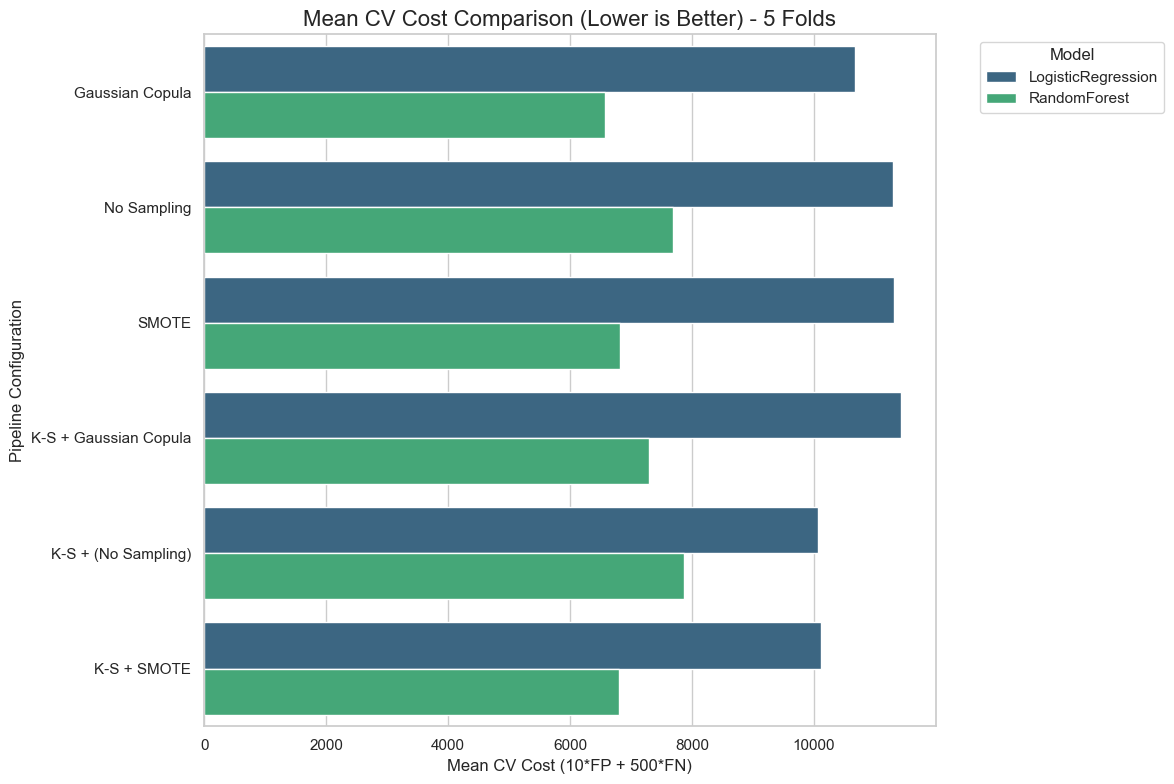

In [9]:
# Visualize the results
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=results_df,
    x='cost_mean',
    y='pipeline_name',
    hue='model',
    orient='h',
    palette='viridis'
)
ax.set_title(f'Mean CV Cost Comparison (Lower is Better) - {N_CV_SPLITS} Folds', fontsize=16)
ax.set_xlabel('Mean CV Cost (10*FP + 500*FN)', fontsize=12)
ax.set_ylabel('Pipeline Configuration', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

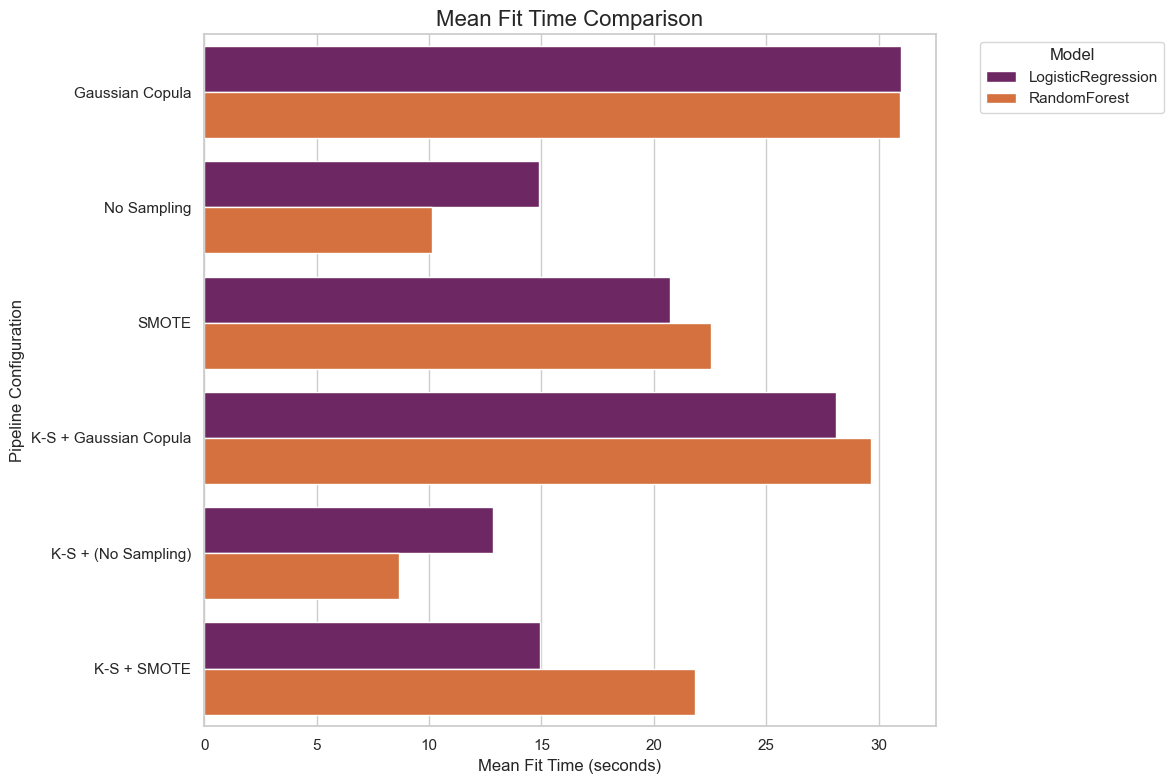

In [17]:
# Visualize fit time
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=results_df,
    x='fit_time_mean',
    y='pipeline_name',
    hue='model',
    orient='h',
    palette='inferno'
)
ax.set_title('Mean Fit Time Comparison', fontsize=16)
ax.set_xlabel('Mean Fit Time (seconds)', fontsize=12)
ax.set_ylabel('Pipeline Configuration', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
# --- CONFIGURE THE WINNING PIPELINE ---
# **Manually update these based on your results from Step 4**

BEST_MODEL_NAME = 'RandomForest'  # e.g., 'RandomForest'
BEST_SAMPLER = 'smote'          # e.g., 'copula'
BEST_KS_SELECT = True             # e.g., True

# ---
print(f"--- Running WINNING pipeline on Test Set ---")
print(f"Model: {BEST_MODEL_NAME}")
print(f"Sampler: {BEST_SAMPLER}")
print(f"K-S Select: {BEST_KS_SELECT}")

# 1. Get the winning model object
best_model = deepcopy(MODELS_TO_TEST[BEST_MODEL_NAME])

# 2. Select the correct datasets
X_train_data = X_train_ks if BEST_KS_SELECT else X_train_raw
X_test_data = X_test_ks if BEST_KS_SELECT else X_test_raw

# 3. Run the final evaluation
# This function handles the tune/refit/evaluate logic automatically
final_run_output = evaluate_on_test(
    best_model,
    X_train_data, y_train_raw,
    X_test_data, y_test_raw,
    sampler=BEST_SAMPLER,
    verbose=True
)

# --- 6. Report Final Metrics ---
final_metrics = final_run_output['metrics']
print("\n--- FINAL TEST SET METRICS ---")
print(f"Total Cost: {final_metrics['Cost']:.0f}")
print(f"AUC: {final_metrics['AUC']:.4f}")
print(f"Macro F1: {final_metrics['MacroF1']:.4f}")
print(f"Recall (pos): {final_metrics['Recall_pos']:.4f}")
print(f"Precision (pos): {final_metrics['Precision_pos']:.4f}")
print(f"Threshold: {final_metrics['Threshold']:.4f}")
print(f"---")
print(f"False Positives (FP): {final_metrics['FP']:.0f} (Cost: {final_metrics['FP'] * 10:.0f})")
print(f"False Negatives (FN): {final_metrics['FN']:.0f} (Cost: {final_metrics['FN'] * 500:.0f})")

--- Running WINNING pipeline on Test Set ---
Model: RandomForest
Sampler: smote
K-S Select: True
--- Tuning Threshold on Validation Set ---
Threshold tuned in 20.79s -> thr=0.120 (Val Cost=5780)
--- Refitting on Full Train Data & Evaluating Test Set ---
Final fit: Balancing with smote...
Test → AUC=0.993 | F1=0.787 | Cost=9480 | Recall=0.976 | Precision=0.424 | fit=28.32s | pred=0.04s | thr=0.120
Test CM (thr=0.120): FP=498, FN=9

--- FINAL TEST SET METRICS ---
Total Cost: 9480
AUC: 0.9929
Macro F1: 0.7872
Recall (pos): 0.9760
Precision (pos): 0.4236
Threshold: 0.1200
---
False Positives (FP): 498 (Cost: 4980)
False Negatives (FN): 9 (Cost: 4500)



--- Final Test Set Confusion Matrix ---


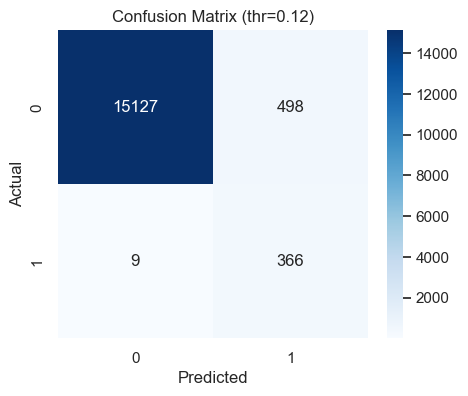

In [16]:
# Plot the final test set confusion matrix
print("\n--- Final Test Set Confusion Matrix ---")

plot_confusion(
    y_test_raw, 
    final_run_output['test_probabilities'], 
    threshold=final_metrics['Threshold']
)
plt.show()